$\large \textbf{Interação e Concorrência 31-Maio-2024 \ LCC}$

* João Manuel Franqueira da Silva, A91638

$\huge \textbf{TP2 - Problemas 3 e 4}$

In [21]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]

In [22]:
from qiskit import *
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import ZGate, MCXGate
import numpy as np

Para auxílio na resolução dos seguintes problemas, utilizaremos uma função que executa um dado circuito

In [23]:
def execute_circuit(qc, shots=1024, binary=False, mode="sampler", reverse=False):
    
    if reverse:
        qc = qc.reverse_bits()
        
    if mode == "sampler":
    
        options = {"shots": shots}

        sampler = Sampler(options=options)
        
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            return probability_dictionary.binary_probabilities()
        else:
            return probability_dictionary
    
    else:
        sv = Statevector.from_instruction(qc)
        return sv

# Exercício 1

Precisamos então de definir a função $\textbf{deutsch\_joza}$ e o oráculo que representa a função $\textbf{f}$ no enunciado.

In [24]:
def deutsch_jozsa(U_f=None, n_qubits=2):

    cr = ClassicalRegister(n_qubits, "measure")
    qr = QuantumRegister(n_qubits, "input")
    ancilla = QuantumRegister(1, "ancilla")
    qc = QuantumCircuit(qr, ancilla, cr)

    # qubits input
    for i in range(n_qubits):
        qc.h(qr[i])

    # ancilla
    qc.x(ancilla)
    qc.h(ancilla)

    qc.barrier()

    # compose circuit wirh U_f
    qc = qc.compose(U_f)

    qc.barrier()

    # interference input qubits
    for i in range(n_qubits):
        qc.h(qr[i])

    qc.barrier()
    
    # measure the input qubits
    qc.measure(qr, cr)

    return qc

In [25]:
def U_f(n_qubits=2):

    qr_input = QuantumRegister(n_qubits, "input")
    qr_ancilla = QuantumRegister(1, "ancilla")

    qc = QuantumCircuit(qr_input, qr_ancilla)

    qc.x(qr_input[2])
    qc.cx(qr_input[2], qr_ancilla)
    qc.x(qr_input[2])

    return qc

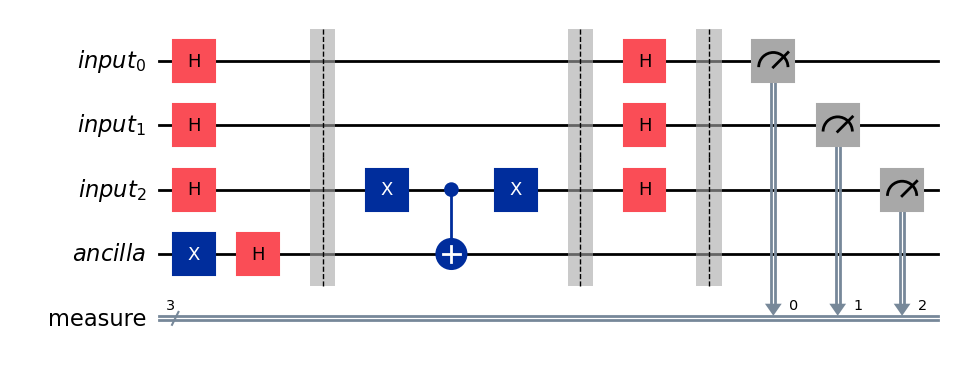

In [26]:
u_f = U_f(n_qubits=3)
qc = deutsch_jozsa(U_f=u_f, n_qubits=3)
qc.draw(output="mpl")

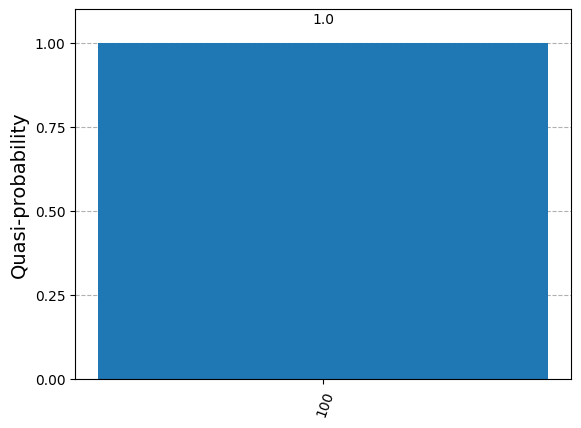

In [27]:
probs = execute_circuit(qc, shots=10000, binary=True, mode="sampler")  
plot_histogram(probs)    

Daqui concluimos que a função é de facto balanceada visto que a probabilidade para $\textbf{|100>}$ é igual a um.

# Exercicio 2

## 2. a)

Definimos então o oráculo para o algorítmo de $\textbf{Grover}$.

In [28]:
def oracle(qr, ancilla, solution=None):
    
    qc = QuantumCircuit(qr,ancilla)
    cx_gate = MCXGate(len(qr), ctrl_state=solution)
    qc = qc.compose(cx_gate)

    qc.barrier()
    return qc

In [29]:
def diffusion_operator(qr, ancilla, n_qubits):

    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr[-1])
    cz = ZGate().control(n_qubits-1, ctrl_state="0"*(n_qubits-1))
    qc = qc.compose(cz)
    qc.x(qr[-1])
    
    qc.h(qr)

    qc.barrier()

    return qc 

Vamos então preparar o estado inicial, aplicando a gate de $\textbf{Hadamard}$ aos qubits de forma a obter sobreposição, no caso da $\textbf{ancilla}$, aplicando primeiro a gate $\textbf{x}$.

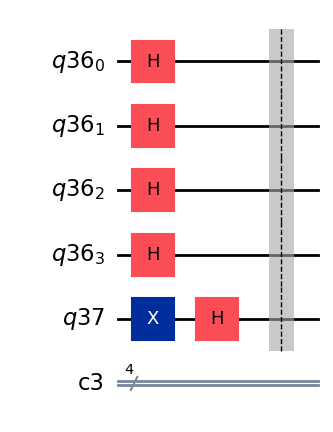

In [30]:
qr=QuantumRegister(4)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()

qc.draw(output="mpl")

Aplicando varias iterações do operador de Grover

Número ótimo de iterações 3


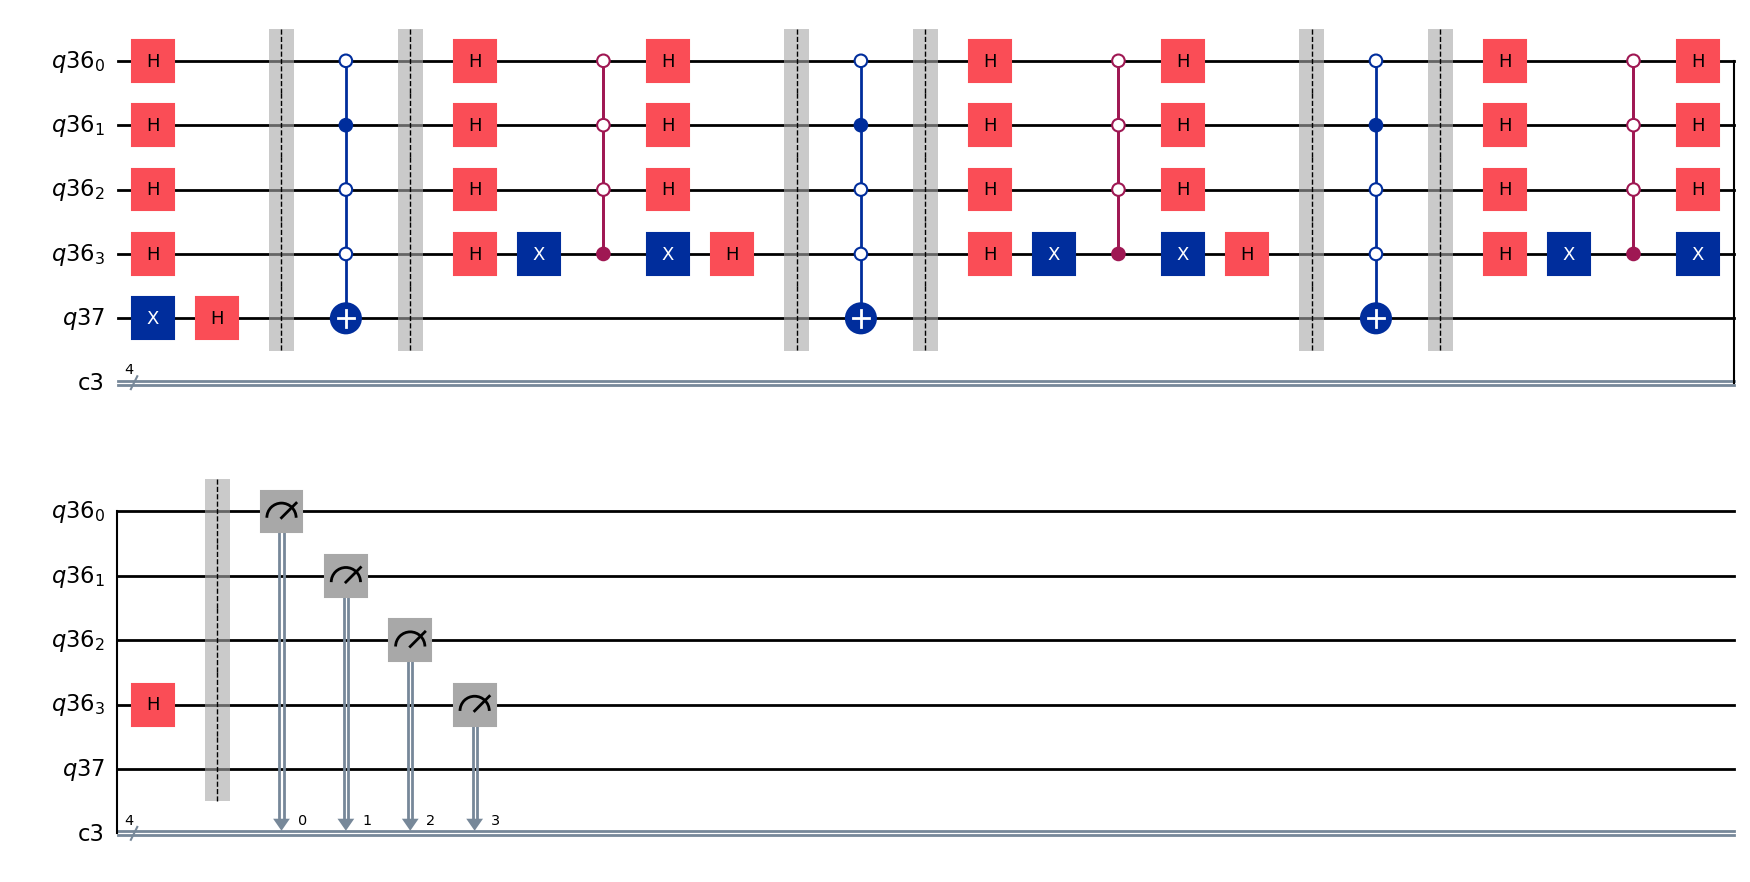

In [31]:
n_qubits = 4
elements = 2**n_qubits

iterations = int(np.floor(np.pi/4 * np.sqrt(elements)))
print("Número ótimo de iterações ", end="")
print(iterations)

for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla,"0010"))
    qc = qc.compose(diffusion_operator(qr,ancilla,n_qubits))


qc.measure(qr,cr)
qc.draw(output="mpl")

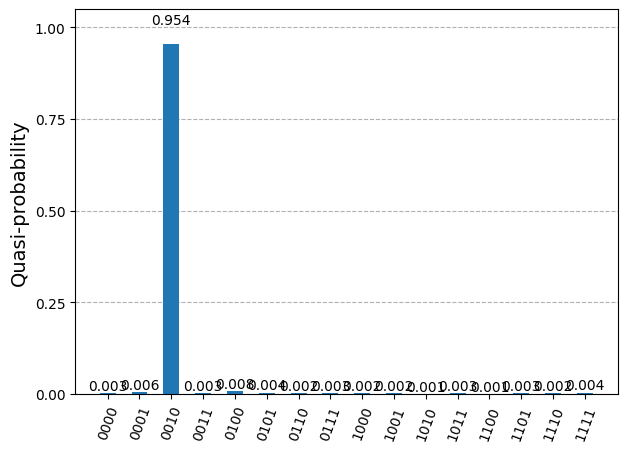

In [32]:
qc.measure(qr,cr)
qc.draw(output="mpl")
counts = execute_circuit(qc, shots=1024, binary=True, mode="sampler")
plot_distribution(counts)

Como podemos verificar, o algorítmo de $\textbf{Grover}$ é aplicado 3 vezes, o número ótimo de iterações, segundo a formula 
$I \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor $, em que:
* N é o número de soluções possivéis
* M é o número de soluções corretas

Observando, a probabilidade de medir o elemento em questão é bastante próxima de 1.

# 2. b)

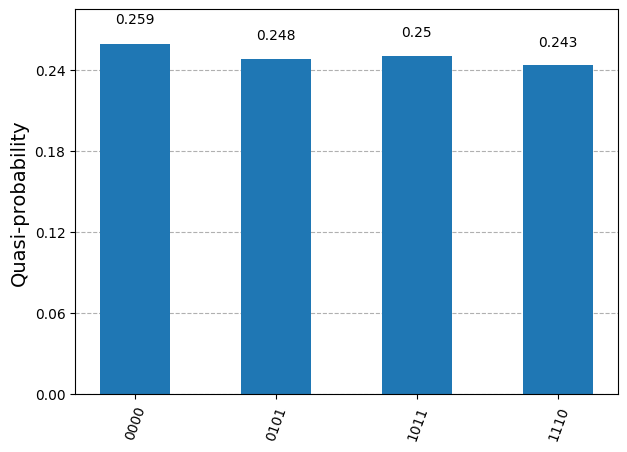

In [33]:
elems=["0000","0101","1011","1110"]

qr=QuantumRegister(4)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()

qc.draw(output="mpl")

n_qubits = 4
elements = 2**n_qubits

iterations = int(np.floor(np.pi/4 * np.sqrt(elements/len(elems))))


for j in range(iterations):
    for elem in elems:
        qc = qc.compose(oracle(qr,ancilla,elem))
        
    qc = qc.compose(diffusion_operator(qr,ancilla,n_qubits))

qc.measure(qr,cr)
qc.draw(output="mpl")
counts = execute_circuit(qc, shots=1024, binary=True, mode="sampler")
plot_distribution(counts)

Obtemos um resultado expectável, com cerca de 25% de probabilidade para cada um dos 4 elementos.

# 2. c

Comecemos por definir o novo oráculo a ser utilizado.

In [34]:
def oracle(qr, ancilla, solution=None):
    
    qc = QuantumCircuit(qr,ancilla)
    qc.cx(qr[3], ancilla)
    qc.barrier()
    return qc

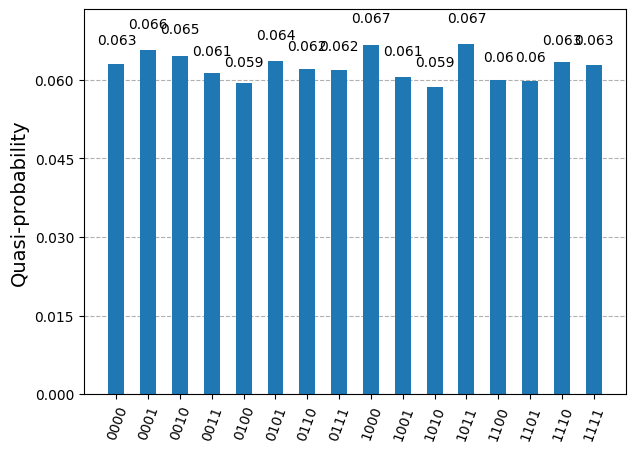

In [35]:
qr=QuantumRegister(4)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()

qc.draw(output="mpl")

n_qubits = 4
elements = 2**n_qubits


iterations = int(np.floor(np.pi/4 * np.sqrt(elements/8)))


for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla))  
    qc = qc.compose(diffusion_operator(qr,ancilla,n_qubits))

qc.measure(qr,cr)
qc.draw(output="mpl")
counts = execute_circuit(qc, shots=10000, binary=True, mode="sampler")
plot_distribution(counts)

Sabemos que os elementos que identificam o oráculo sao os tais cujo 1º qubit é igual a 1. 

Porém, podemos ver que os resultados obtidos não são corretos, visto que seria esperado, obter as probabilidades dos 8 elementos marcados pelo oráculo.